In [235]:
import pandas as pd


#데이터 불러오기
move1 = pd.read_csv('./move_as-pcs1kr.csv')
move2 = pd.read_csv('./move_as-pcs2kr.csv')
move3 = pd.read_csv('./move_as-pcs3kr.csv')
move4 = pd.read_csv('./move_kr-bsc20.csv')

#Baltic_Main, Desert_Main

#맵 분리
move1_erangel = move1[move1['map_name'] == 'Baltic_Main']
move2_erangel = move2[move2['map_name'] == 'Baltic_Main']
move3_erangel = move3[move3['map_name'] == 'Baltic_Main']
move4_erangel = move4[move4['map_name'] == 'Baltic_Main']
move1_miramar = move1[move1['map_name'] == 'Desert_Main']
move2_miramar = move2[move2['map_name'] == 'Desert_Main']
move3_miramar = move3[move3['map_name'] == 'Desert_Main']
move4_miramar = move4[move4['map_name'] == 'Desert_Main']

#합치기
move_erangel = pd.concat([move1_erangel,move2_erangel,move3_erangel,move4_erangel], ignore_index=True)
move_miramar = pd.concat([move1_miramar,move2_miramar,move3_miramar,move4_miramar], ignore_index=True)

outlier = [
    'f566ed1a-9187-4937-a435-3b31ed881f2d',
    '3bb55936-e760-45eb-a18d-3e8f50908f8b',
    '618291a3-d2a6-4b33-be8a-0bcd96e7760a'
]

#이상치 제거
move_erangel = move_erangel[~move_erangel['match_id'].isin(outlier)]
move_miramar = move_miramar[~move_miramar['match_id'].isin(outlier)]

#map_name 제거
move_erangel = move_erangel.drop(columns='map_name')
move_miramar = move_miramar.drop(columns='map_name')

# erangel check_z : 특정 z이상 인지, miramar count : 얼마나 있었는 지
#move_erangel['check_z'] = 0
move_miramar['count'] = 1

In [236]:
#맵 크기 : 816000 * 816000
map_size = 816000

def binning_move(move_data, bin_num):  # bin_num단위로 나눔

    move_data['y'] = map_size - move_data['y']  # y좌표 반전
    move_data['x'] = (move_data['x'] / bin_num).round().astype(int)
    move_data['y'] = (move_data['y'] / bin_num).round().astype(int)
    move_data['z'] = move_data['z'].astype(int)


def timestamp(move_data):  # timestamp 정리
    move_data['timestamp'] = pd.to_datetime(move_data['timestamp'])
    move_data['timestamp'] = move_data['timestamp'].dt.strftime('%H%M%S').astype(int)


binning_move(move_erangel, 100)
#binning_move(move_miramar, 4000)

timestamp(move_erangel)
#timestamp(move_miramar)


In [237]:
def filter_by_time(data):  # 12분에서 25분 사이의 데이터만 남김
    first_timestamp = data['timestamp'].min()
    data['timestamp'] -= first_timestamp
    return data[(data['timestamp'] >= 1200) & (data['timestamp'] <= 2500)]


move_erangel = move_erangel.groupby(['match_id', 'player_name']).apply(filter_by_time).reset_index(drop=True)
#move_miramar = move_miramar.groupby(['match_id', 'player_name']).apply(filter_by_time).reset_index(drop=True)

#z체크
def filter_by_z(data):
    if data['z'] >= 1500:
        return 1
    else:
        return 0

move_erangel['check_z'] = move_erangel.apply(filter_by_z, axis=1)

In [238]:
#저장
move_erangel.to_csv('./move_erangel4.csv', index=False)
#move_miramar.to_csv('./move_miramar.csv', index=False)

In [239]:
rank = pd.read_csv('./Baltic_kill_clustered_rank.csv')
rank.rename(columns={'killer': 'player_name'}, inplace=True)

p1 = pd.read_csv('./pro_data_as-pcs1kr.csv')
p2 = pd.read_csv('./pro_data_as-pcs2kr.csv')
p3 = pd.read_csv('./pro_data_as-pcs3kr.csv')
p4 = pd.read_csv('./pro_data2.csv')

p1_erangel = p1[p1['map_name'] == 'Erangel (Remastered)']
p2_erangel = p2[p2['map_name'] == 'Erangel (Remastered)']
p3_erangel = p3[p3['map_name'] == 'Erangel (Remastered)']
p4_erangel = p4[p4['map_name'] == 'Erangel (Remastered)']

p_erangel = pd.concat([p1_erangel,p2_erangel,p3_erangel,p4_erangel], ignore_index=True)
move_erangel.rename(columns={'player_name': 'player_id'}, inplace=True)

In [241]:
#data = pd.merge(move_erangel, rank, on=['player_name', 'match_id'])
data = pd.merge(move_erangel, p_erangel, on=['player_id', 'match_id'])
data.to_csv('./eragnel_move_final.csv', index = False)

In [242]:
high_altitude_visits = data.groupby(['match_id', 'player_name','team_rank'])['check_z'].sum().reset_index()
high_altitude_visits.rename(columns={'check_z': 'count'}, inplace=True)

print(high_altitude_visits)

                                  match_id player_name  team_rank  count
0     00d05c35-8b9e-4207-bbc4-4f4d29bf1e7e      2HEART          2     27
1     00d05c35-8b9e-4207-bbc4-4f4d29bf1e7e       ADDER          9     51
2     00d05c35-8b9e-4207-bbc4-4f4d29bf1e7e        AKAD          9     19
3     00d05c35-8b9e-4207-bbc4-4f4d29bf1e7e     ALPHACA          8     72
4     00d05c35-8b9e-4207-bbc4-4f4d29bf1e7e   AMERICANO          5     58
...                                    ...         ...        ...    ...
3845  fd356f2d-57c1-482c-ba87-b2fc41c877b6      WICK2D          2     76
3846  fd356f2d-57c1-482c-ba87-b2fc41c877b6       YACHA         15     26
3847  fd356f2d-57c1-482c-ba87-b2fc41c877b6     YEOWOOK         15     17
3848  fd356f2d-57c1-482c-ba87-b2fc41c877b6     YUNJONG         11     21
3849  fd356f2d-57c1-482c-ba87-b2fc41c877b6      ZENITH         12     18

[3850 rows x 4 columns]


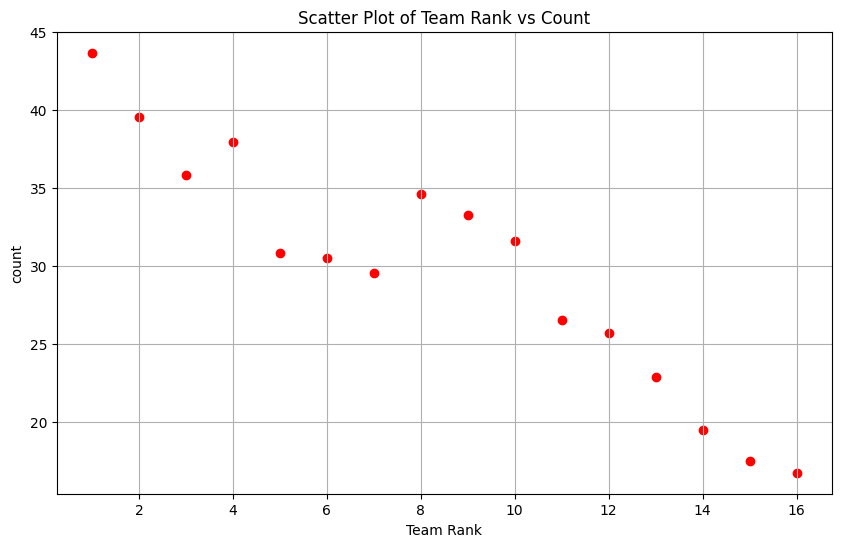

              count  team_rank
count      1.000000  -0.938131
team_rank -0.938131   1.000000
done


In [243]:
import matplotlib.pyplot as plt



move_mean =high_altitude_visits.groupby(['team_rank'])['count'].mean().reset_index()
#move_miramar_mean.to_csv('./dataset/miramar_final_mean.csv', index=False)

plt.figure(figsize=(10, 6))
plt.scatter(move_mean['team_rank'], move_mean['count'], alpha=1, color='red')
plt.title('Scatter Plot of Team Rank vs Count')
plt.xlabel('Team Rank')
plt.ylabel('count')
plt.grid(True)
plt.show()


relevant = move_mean[['count', 'team_rank']]


relevant= relevant.dropna()


correlation = relevant.corr()


print(correlation)
print("done")

Mann-Whitney U Test P-value: 2.248339890702664e-51


C:\Users\admin\AppData\Local\Temp\ipykernel_15188\1355674523.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(high_altitude_data['team_rank'], label='High Altitude',shade=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_15188\1355674523.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(low_altitude_data['team_rank'], label='Low Altitude',shade=True)


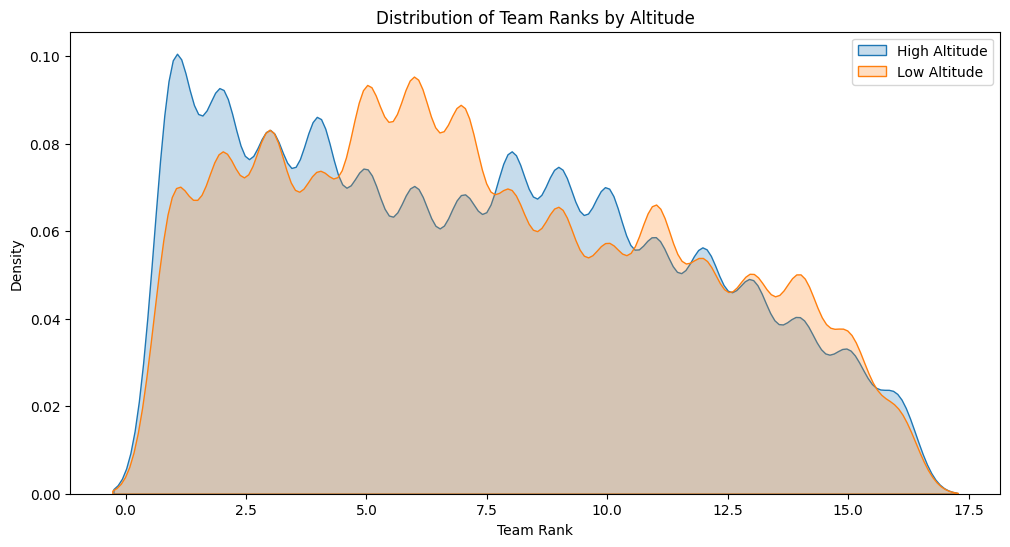

In [244]:

from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt


high_altitude_data = data[data['check_z'] == 1]
low_altitude_data = data[data['check_z'] == 0]


u_stat, p_value = mannwhitneyu(high_altitude_data['team_rank'], low_altitude_data['team_rank'])


print(f"Mann-Whitney U Test P-value: {p_value}")  #이 결과가 우연에 의하여 발생했는지 알아보기 위해 p-value값 출력


plt.figure(figsize=(12, 6))
sns.kdeplot(high_altitude_data['team_rank'], label='High Altitude',shade=True)
sns.kdeplot(low_altitude_data['team_rank'], label='Low Altitude',shade=True)
plt.title('Distribution of Team Ranks by Altitude')
plt.xlabel('Team Rank')
plt.ylabel('Density')
plt.legend()
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_15188\3586485136.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(high_altitude_data['team_rank'], label=f'High Altitude', shade=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_15188\3586485136.py:27: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(low_altitude_data['team_rank'], label=f'Low Altitude', shade=True)


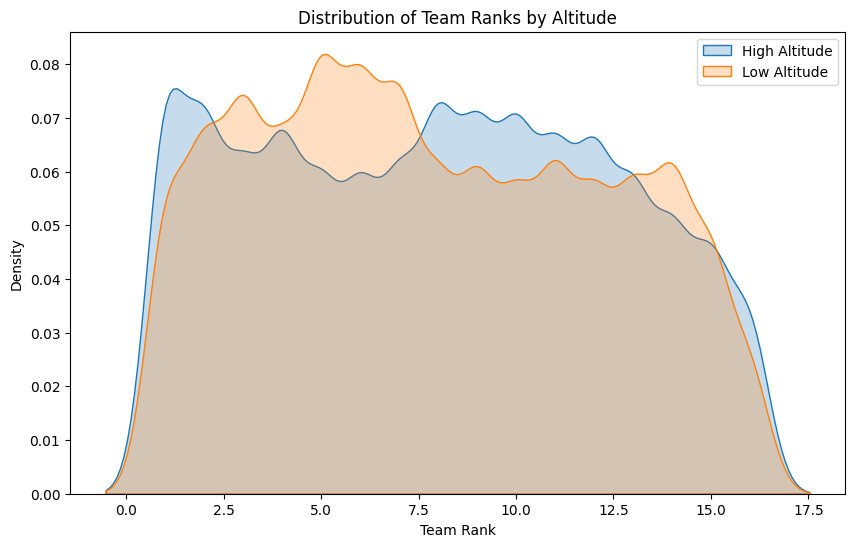

C:\Users\admin\AppData\Local\Temp\ipykernel_15188\3586485136.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(high_altitude_data['team_rank'], label=f'High Altitude', shade=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_15188\3586485136.py:27: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(low_altitude_data['team_rank'], label=f'Low Altitude', shade=True)


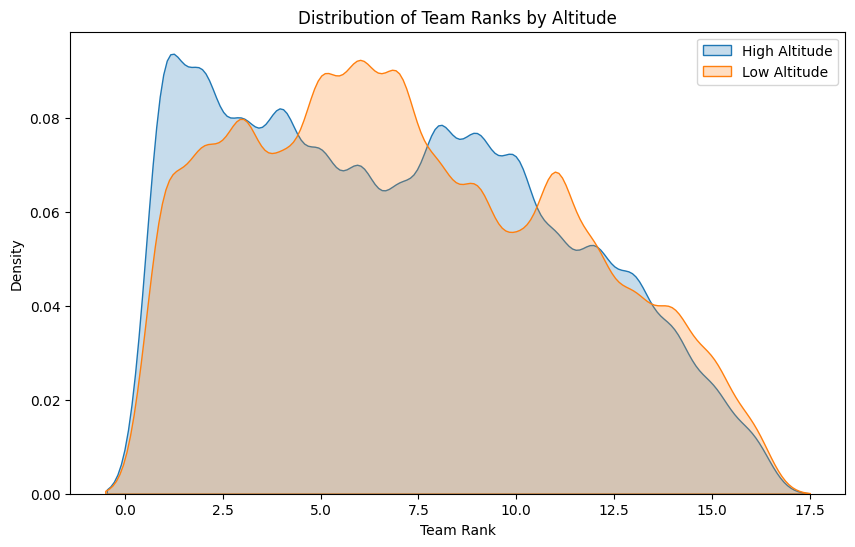

C:\Users\admin\AppData\Local\Temp\ipykernel_15188\3586485136.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(high_altitude_data['team_rank'], label=f'High Altitude', shade=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_15188\3586485136.py:27: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(low_altitude_data['team_rank'], label=f'Low Altitude', shade=True)


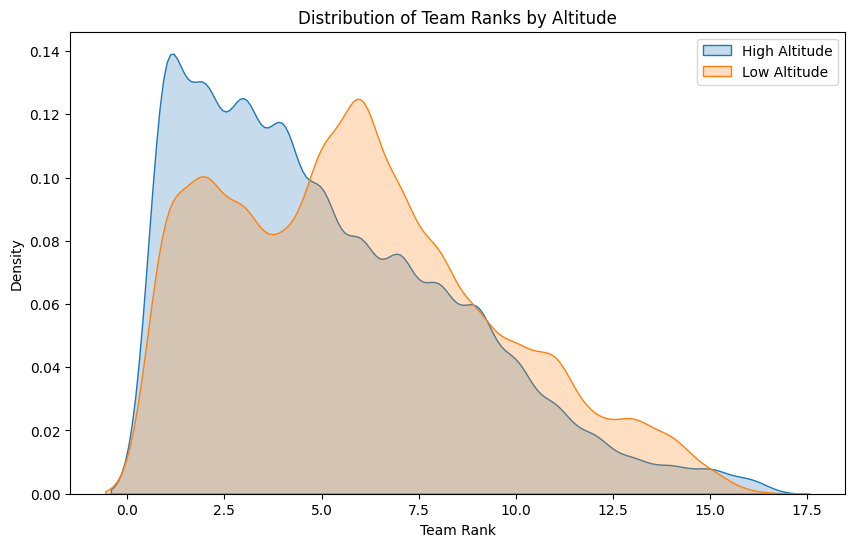

In [245]:
#시간 별로 데이터를 보여주기 위해서, 데이터를 시간 별로 나눔

data['minutes'] = data['timestamp'] // 100
data['seconds'] = data['timestamp'] % 100


data['total_minutes'] = data['minutes'] + data['seconds'] / 60


start_times = data.groupby('match_id')['total_minutes'].transform('min')


data['minutes_passed'] = data['total_minutes'] - start_times


data['time_interval'] = (data['minutes_passed'] // 5).astype(int)   


for interval in range(data['time_interval'].max() + 1):
    interval_data = data[data['time_interval'] == interval]
    high_altitude_data = interval_data[interval_data['check_z'] == 1]
    low_altitude_data = interval_data[interval_data['check_z'] == 0]
    

    plt.figure(figsize=(10, 6))
    sns.kdeplot(high_altitude_data['team_rank'], label=f'High Altitude', shade=True)
    sns.kdeplot(low_altitude_data['team_rank'], label=f'Low Altitude', shade=True)
    plt.title(f'Distribution of Team Ranks by Altitude')
    plt.xlabel('Team Rank')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

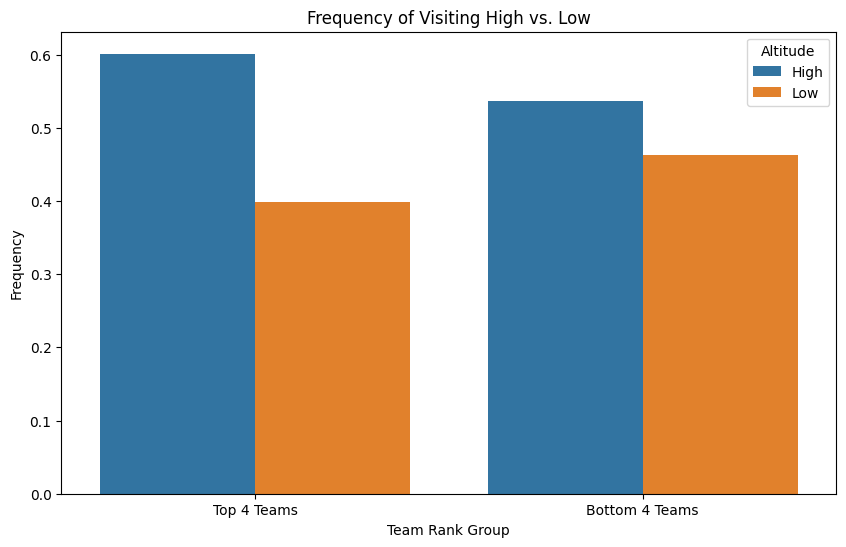

In [247]:
#상위 4팀 하위 4팀의 고도가 높은 지역과 아닌 지역에 머무르는 정도를 알아보기 위한 시각화 작업

top_teams = data[data['team_rank'] <= 4]
bottom_teams = data[data['team_rank'] >= 13]


top_high_freq = top_teams[top_teams['check_z'] == 1].shape[0] / top_teams.shape[0]
top_low_freq = top_teams[top_teams['check_z'] == 0].shape[0] / top_teams.shape[0]
bottom_high_freq = bottom_teams[bottom_teams['check_z'] == 1].shape[0] / bottom_teams.shape[0]
bottom_low_freq = bottom_teams[bottom_teams['check_z'] == 0].shape[0] / bottom_teams.shape[0]


frequency_data = pd.DataFrame({
    'Group': ['Top 4 Teams', 'Top 4 Teams', 'Bottom 4 Teams', 'Bottom 4 Teams'],
    'Altitude': ['High', 'Low', 'High', 'Low'],
    'Frequency': [top_high_freq, top_low_freq, bottom_high_freq, bottom_low_freq]
})


plt.figure(figsize=(10, 6))
sns.barplot(x='Group', y='Frequency', hue='Altitude', data=frequency_data)
plt.title('Frequency of Visiting High vs. Low')
plt.xlabel('Team Rank Group')
plt.ylabel('Frequency')
plt.legend(title='Altitude')
plt.show()